In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Load images

100%|██████████| 23788/23788 [04:06<00:00, 96.45it/s]


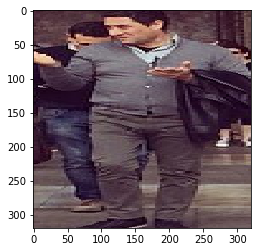

In [0]:
import shutil
from PIL import Image
from tqdm import tqdm
import pandas as pd

shape = (320,320)

crop_imgs = False
generate_new_boxes = True

labelpath = '/content/gdrive/My Drive/colab/data/db/trouser_27k_join.csv'
labels = pd.read_csv(labelpath)

for i in tqdm(labels.index, position=0): 
    url = labels['url'][i]
      
    if crop_imgs:
        im = Image.open(url)
        if generate_new_boxes:
            x1,y1,x2,y2 = labels['new_x1'][i],labels['new_y1'][i],labels['new_x2'][i],labels['new_y2'][i]
        else:
            x1,y1,x2,y2 = labels['x1'][i],labels['y1'][i],labels['x2'][i],labels['y2'][i]
        cropped = im.crop((x1,y1,x2,y2))
        cropped = cropped.resize(shape)
        
        trainfile = 'data/all/' + labels['file'][i]
        testfile = 'data/all/' + labels['file'][i]
        if labels['test'][i]: 
          cropped.save(testfile)
        else:             
            cropped.save(trainfile)
        im.close()
        cropped.close()
    else:
        if labels['test'][i]: shutil.copy2(url,'data/all/')
        else: shutil.copy2(url,'data/all/')

In [0]:
#!ls
#!rm -r data/fullbody
#!mkdir 'data/fullbody'
#!cp -r data/cropped/train/. data/fullbody/
#!cp -r data/cropped/test/. data/fullbody/
#!rm -r data/cropped
#!ls 'data/fullbody/' | wc -l
#![ -f data/all/b5d857e5999a7aa101ce8c640314014f_901362730850049440_389261526.jpg ] && echo "File exist" || echo "File does not exist"


mkdir: cannot create directory ‘data/fullbody’: File exists
23908


Preprocess and load dataset

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import os, pickle
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/gdrive/My Drive/colab/uda')
from autoaugment import AugPolicy,SubPolicy
from data_util import *


labelpath = '/content/gdrive/My Drive/colab/data/db/trouser_27k_join.csv'
imagepath = 'data/all/'
shape = (128,128)
testsplit = 0.1
cvsplit = 0.1
unlabelmultiplier = 2
num_sample = 2000


In [0]:
xtrain, xval, ytrain, yval,xtest,ytest,xunlabel,xunlabel_da, mlb,dict_cat = load_dataset(imagepath,labelpath)

data/all/4f12af3323bb9ae59000607d9386cadc_695284041376892015_6179384.jpg


show an image

(157, 128, 128, 3) (157, 41)


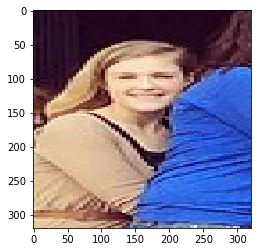

In [0]:
print(xtest.shape, ytest.shape)
#idx = 0
#show_image(xtest,idx)

filename = 'data/all/4f12af3323bb9ae59000607d9386cadc_695284041376892015_6179384.jpg'

img=Image.open(filename)
plt.imshow(img)

save data and mlb

In [0]:
path = '/content/gdrive/My Drive/colab/data/db/'
np.savez(path+'uda_data', xtrain=xtrain,ytrain=ytrain,xtest=xtest,ytest=ytest, \
             xval=xval,yval=yval,xunlabel=xunlabel,xunlabel_da=xunlabel_da)
mlbPath = '/content/gdrive/My Drive/colab/'+'uda/saved_models/mlb.pickle'
saveMlb(mlb,mlbPath)

[INFO] serializing label binarizer...


load saved data and mlb

In [0]:
path = '/content/gdrive/My Drive/colab/data/db/'
data = np.load(path+'/uda_data.npz')
xtrain,ytrain = data['xtrain'],data['ytrain']
xtest,ytest = data['xtest'],data['ytest']
xval,yval = data['xval'],data['xunlabel_da']
xunlabel,xunlabel_da = data['xunlabel'],data['xunlabel_da'] 
mlbPath = '/content/gdrive/My Drive/colab/'+'uda/saved_models/mlb.pickle'
mlb = pickle.loads(open(mlbPath, "rb").read())

setup

In [0]:
import os,pickle
from keras import losses
import numpy as np

from keras.preprocessing import image
import keras.backend as K

from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Activation
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Flatten

import sys
sys.path.append('/content/gdrive/My Drive/colab/uda')
from uda import SmallerVGGNet, UDA

In [0]:
shape = (128, 128, 3)
batch_size = 16
dropout = 0.5
epochs = 10
alpha = 0.01
INIT_LR = 1e-3


Training without UDA

In [0]:
path = '/content/gdrive/My Drive/colab/'
num_classes = len(mlb.classes_)
uda = UDA(dropout,num_classes)

uda.setup_generator()
        
callbacks = []
callbacks.append(ModelCheckpoint(filepath= '/content/gdrive/My Drive/colab/uda/saved_models/weights.hdf5',
                                           verbose=1, save_best_only=True))
        
model = uda.create_model()

uda.train_model(model,callbacks,0)

In [0]:
weight_path = '/content/gdrive/My Drive/colab/uda/saved_models/weights.hdf5'
model = uda.load_weights(weight_path)

[INFO] loading network...


In [0]:
probs = model.predict(xtest)
ypred = (probs>0.5).astype(int)
#acc = np.mean(ypred==ytest[:,31])
#print(acc)

categories = ['clothing_pattern', 'major_color', 'sleeve_length', 'neckline_shape', 'clothing_category', 'multiple_layers']
print_acc(categories,dict_cat,probs,ytest)
        
binary_categories = ['Trouser', 'collar_presence', 'necktie', \
                            'wearing_glasses', 'wearing_hat','wearing_jacket', 'wearing_scarf']
        
print_acc_bin(binary_categories,dict_cat,probs)

Accuracy for clothing_pattern is 0.7261146496815286
Accuracy for major_color is 0.2229299363057325
Accuracy for sleeve_length is 0.22929936305732485
Accuracy for neckline_shape is 0.6878980891719745
Accuracy for clothing_category is 1.0
Accuracy for multiple_layers is 0.8662420382165605
Accuracy for Trouser is 0.9554140127388535
Accuracy for collar_presence is 0.9363057324840764
Accuracy for necktie is 1.0
Accuracy for wearing_glasses is 0.9299363057324841
Accuracy for wearing_hat is 0.9426751592356688
Accuracy for wearing_jacket is 0.9490445859872612
Accuracy for wearing_scarf is 0.9745222929936306


Check for an example

('Brown', 'Dress', 'Long sleeve', 'Multiple layers', 'Round', 'Solid', 'wearing_jacket')
Black: 3.23%
Blue: 28.10%
Brown: 0.21%
Cyan: 0.06%
Dress: 85.89%
Floral: 55.19%
Folded: 23.95%
Graphics: 6.38%
Gray: 1.39%
Green: 0.82%
Long sleeve: 42.43%
More than 1 color: 53.00%
Multiple layers: 13.28%
No sleeve: 20.94%
One layer: 89.53%
Orange: 0.20%
Outerwear: 2.28%
Pink: 5.80%
Plaid: 8.30%
Purple: 0.45%
Red: 2.27%
Round: 59.60%
Shirt: 4.87%
Short sleeve: 25.90%
Solid: 19.53%
Spotted: 2.02%
Striped: 7.57%
Suit: 0.55%
Sweater: 1.01%
T-shirt: 5.21%
Tank top: 0.31%
Trouser: 21.72%
V-shape: 14.37%
White: 30.77%
Yellow: 0.15%
collar_presence: 40.39%
necktie: 0.61%
wearing_glasses: 37.67%
wearing_hat: 1.08%
wearing_jacket: 3.67%
wearing_scarf: 0.16%


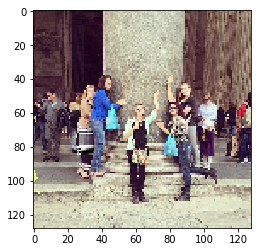

In [0]:
idx = 0
show_image(xtest,idx)
labels = mlb.inverse_transform(ytest)
print(labels[0])
for (label, p) in zip(mlb.classes_, probs[0]):
    	    print("{}: {:.2f}%".format(label, p * 100))

Training with uda

In [0]:
model = uda.create_model()

uda.train_model(model,callbacks,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


[INFO] training network...
Epoch 1/10
79/79 [==============================] - 6s 80ms/step - loss: nan - acc: 0.0728 - val_loss: nan - val_acc: 0.1915

Epoch 00001: val_loss did not improve from inf
Epoch 2/10
79/79 [==============================] - 5s 57ms/step - loss: nan - acc: 0.1021 - val_loss: nan - val_acc: 0.1702

Epoch 00002: val_loss did not improve from inf
Epoch 3/10
79/79 [==============================] - 5s 59ms/step - loss: nan - acc: 0.0862 - val_loss: nan - val_acc: 0.1277

Epoch 00003: val_loss did not improve from inf
Epoch 4/10
79/79 [==============================] - 5s 59ms/step - loss: nan - acc: 0.0949 - val_loss: nan - val_acc: 0.0993

Epoch 00004: val_loss did not improve from inf
Epoch 5/10
79/79 [==============================] - 5s 59ms/step - loss: nan - acc: 0.0855 - val_loss: nan - val_acc: 0.0142

Epoch 00005: val_loss did not improve from inf
Epoch 6/10
79/79 [==============================] - 5s 60ms/step - loss: nan - acc: 0.1060 - val_loss: nan -

In [0]:
probs = model.predict(xtest)
ypred = (probs>0.5).astype(int)
#acc = np.mean(ypred==ytest[:,31])
#print(acc)

categories = ['clothing_pattern', 'major_color', 'sleeve_length', 'neckline_shape', 'clothing_category', 'multiple_layers']
print_acc(categories,dict_cat,probs,ytest)
        
binary_categories = ['Trouser', 'collar_presence', 'necktie', \
                            'wearing_glasses', 'wearing_hat','wearing_jacket', 'wearing_scarf']
        
print_acc_bin(binary_categories,dict_cat,probs)


Accuracy for clothing_pattern is 0.7261146496815286
Accuracy for major_color is 0.2356687898089172
Accuracy for sleeve_length is 0.47770700636942676
Accuracy for neckline_shape is 0.6878980891719745
Accuracy for clothing_category is 1.0
Accuracy for multiple_layers is 0.8662420382165605
Accuracy for Trouser is 0.9745222929936306
Accuracy for collar_presence is 0.8726114649681529
Accuracy for necktie is 1.0
Accuracy for wearing_glasses is 0.9299363057324841
Accuracy for wearing_hat is 0.9426751592356688
Accuracy for wearing_jacket is 0.9490445859872612
Accuracy for wearing_scarf is 0.9745222929936306


Check for an example

In [0]:
labels = mlb.inverse_transform(ytest)
print(labels[0])

('Brown', 'Dress', 'Long sleeve', 'Multiple layers', 'Round', 'Solid', 'wearing_jacket')


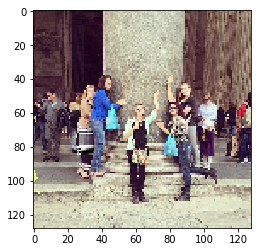

In [0]:
idx = 0
show_image(xtest,idx)


For unlabeled data

trouser: 1


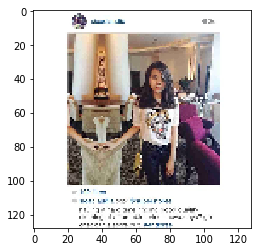

In [0]:
probs = model.predict(xunlabel)
idx = 0
show_image(xunlabel,idx)
ypred = (probs>0.5).astype(int)
print('trouser:',ypred[idx,31])

Output prediction

In [0]:
with open('/content/gdrive/My Drive/colab/uda/pred.txt', 'w') as f:
    for item in ypred:
        f.write("%s\n" % item)
print('Done')

Done
